In [1]:
import os
import random
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


class AnimalDataset(Dataset):
    def __init__(self, root_dir, selected_classes, images_per_class=20, image_size=64):
        self.data = []
        self.labels = []
        self.class_to_idx = {cls_name: idx for idx, cls_name in enumerate(selected_classes)}
        self.transform = transforms.Compose([
            transforms.Resize((image_size, image_size)),
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1]
        ])

        for cls in selected_classes:
            class_dir = os.path.join(root_dir, cls)
            images = os.listdir(class_dir)
            selected_images = random.sample(images, min(images_per_class, len(images)))
            for img_name in selected_images:
                img_path = os.path.join(class_dir, img_name)
                self.data.append(img_path)
                self.labels.append(self.class_to_idx[cls])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert("RGB")
        image = self.transform(image)
        return image, label




Using device: cuda


In [2]:
# Example usage:
if __name__ == "__main__":
    selected_classes = ['Bear', 'Bird', 'Cat', 'Cow', 'Deer']
    dataset = AnimalDataset(root_dir='../animal_data', selected_classes=selected_classes)
    dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

    # Test one batch
    for images, labels in dataloader:
        print("Image batch shape:", images.shape)
        print("Label batch:", labels)
        break


Image batch shape: torch.Size([16, 3, 64, 64])
Label batch: tensor([0, 4, 2, 2, 4, 4, 1, 3, 3, 1, 4, 0, 4, 3, 2, 1])


In [3]:
import torch
import torch.nn.functional as F

# Define beta schedule and precompute alphas
def get_noise_schedule(T=1000, beta_start=1e-4, beta_end=0.02):
    betas = torch.linspace(beta_start, beta_end, T)
    alphas = 1. - betas
    alpha_bars = torch.cumprod(alphas, dim=0)
    return betas.to(device), alphas.to(device), alpha_bars.to(device)

# Forward sampling function (q_sample)
def q_sample(x_start, t, alpha_bars, noise=None):
    if noise is None:
        noise = torch.randn_like(x_start)

    sqrt_alpha_bar = torch.sqrt(alpha_bars[t]).view(-1, 1, 1, 1)
    sqrt_one_minus_alpha_bar = torch.sqrt(1 - alpha_bars[t]).view(-1, 1, 1, 1)

    x_t = sqrt_alpha_bar * x_start + sqrt_one_minus_alpha_bar * noise
    return x_t, noise


In [4]:
import torch.nn as nn

class SinusoidalTimeEmbedding(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, t):
        half_dim = self.dim // 2
        emb = torch.exp(torch.arange(half_dim, device=t.device) * (-torch.log(torch.tensor(10000.0)) / half_dim))
        emb = t[:, None] * emb[None, :]
        emb = torch.cat([torch.sin(emb), torch.cos(emb)], dim=1)
        return emb


In [5]:
class DenoiseModel(nn.Module):
    def __init__(self, time_dim=256):
        super().__init__()
        self.time_mlp1 = nn.Sequential(
            SinusoidalTimeEmbedding(time_dim),
            nn.Linear(time_dim, 128),
            nn.ReLU()
        )   

        self.time_mlp2 = nn.Sequential(
            SinusoidalTimeEmbedding(time_dim),
            nn.Linear(time_dim, 64),
            nn.ReLU()
        )

        self.conv1 = nn.Conv2d(3, 64, 3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv3 = nn.Conv2d(128, 128, 3, padding=1)
        self.conv4 = nn.Conv2d(128, 64, 3, padding=1)
        self.conv5 = nn.Conv2d(64, 3, 3, padding=1)

        self.act = nn.ReLU()
        self.dropout = nn.Dropout(0.1)

    def forward(self, x, t):
        # Embed time and reshape to add to conv features
        t_emb1 = self.time_mlp1(t)[:, :, None, None]  # for 128-channel layers
        t_emb2 = self.time_mlp2(t)[:, :, None, None]  # for 64-channel layers
        
        
        h = self.act(self.conv1(x))
        h = self.act(self.conv2(h) + t_emb1)
        h = self.act(self.conv3(h))
        h = self.act(self.conv4(h) + t_emb2)
        h = self.conv5(h)  # output predicted noise

        return h


In [6]:
model = DenoiseModel().to(device)

In [7]:
def custom_loss(predicted_noise, true_noise):
    return torch.mean((predicted_noise - true_noise) ** 2)


In [8]:
from torch import optim

optimizer = optim.Adam(model.parameters(), lr=1e-4)
epochs = 100
T = 1000
all_losses = []
model.train()
betas, alphas, alpha_bars = get_noise_schedule(T=1000)

for epoch in range(epochs):
    epoch_loss = 0
    for step, (x, _) in enumerate(dataloader):
        x = x.to(device)
        t = torch.randint(1, T, (x.size(0),), device=device).long()

        x_t, noise = q_sample(x, t, alpha_bars)

        predicted_noise = model(x_t, t)

        loss = custom_loss(predicted_noise, noise)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        if step % 100 == 0:
            print(f"Epoch {epoch} | Step {step} | Loss: {loss.item():.4f}")
    avg_epoch_loss = epoch_loss / len(dataloader)
    all_losses.append(avg_epoch_loss)
    print(f"Epoch {epoch} completed. Average Loss: {avg_epoch_loss:.4f}")


Epoch 0 | Step 0 | Loss: 1.0293
Epoch 0 completed. Average Loss: 1.0050
Epoch 1 | Step 0 | Loss: 0.9958
Epoch 1 completed. Average Loss: 0.9810
Epoch 2 | Step 0 | Loss: 0.9698
Epoch 2 completed. Average Loss: 0.9446
Epoch 3 | Step 0 | Loss: 0.9114
Epoch 3 completed. Average Loss: 0.8903
Epoch 4 | Step 0 | Loss: 0.8526
Epoch 4 completed. Average Loss: 0.8046
Epoch 5 | Step 0 | Loss: 0.7818
Epoch 5 completed. Average Loss: 0.7125
Epoch 6 | Step 0 | Loss: 0.6398
Epoch 6 completed. Average Loss: 0.6067
Epoch 7 | Step 0 | Loss: 0.5621
Epoch 7 completed. Average Loss: 0.5030
Epoch 8 | Step 0 | Loss: 0.4591
Epoch 8 completed. Average Loss: 0.4377
Epoch 9 | Step 0 | Loss: 0.3918
Epoch 9 completed. Average Loss: 0.3455
Epoch 10 | Step 0 | Loss: 0.2998
Epoch 10 completed. Average Loss: 0.2867
Epoch 11 | Step 0 | Loss: 0.2917
Epoch 11 completed. Average Loss: 0.2313
Epoch 12 | Step 0 | Loss: 0.3671
Epoch 12 completed. Average Loss: 0.2257
Epoch 13 | Step 0 | Loss: 0.1384
Epoch 13 completed. Avera

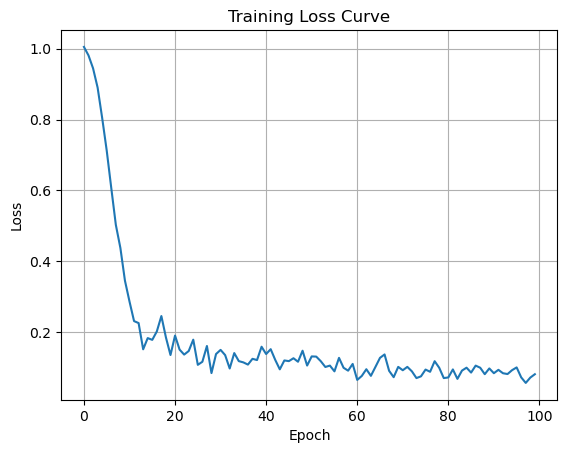

In [9]:
import matplotlib.pyplot as plt


plt.plot(all_losses)
plt.title("Training Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid()
plt.savefig("training_loss.png")  # Save the plot
plt.show()


In [10]:
torch.save(model.state_dict(), "denoise_model.pth")

In [11]:

batch_size =1

x_t = torch.randn((batch_size, 3, 32, 32)).to(device)  # e.g., for CIFAR-10

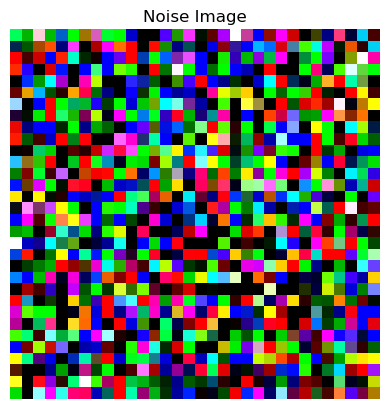

In [12]:
import matplotlib.pyplot as plt
import torchvision.transforms as T

# Convert and clamp to [0, 1] if needed
img = x_t[0].detach().cpu()
img = torch.clamp(img, 0.0, 1.0)
img = T.ToPILImage()(img)

plt.imshow(img)
plt.axis('off')
plt.title("Noise Image")
plt.show()


In [13]:

betas, alphas, alpha_bars = get_noise_schedule(T=1000)
T = 1000  # Total diffusion steps
with torch.no_grad():

    for t in reversed(range(1, T)):
        t_batch = torch.full((batch_size,), t, device=device, dtype=torch.long)

        # 1. Predict noise using the trained model
        predicted_noise = model(x_t, t_batch)

        # 2. Estimate the clean image (x0) from noisy image (x_t)
        alpha = alphas[t]
        alpha_bar = alpha_bars[t]
        beta = betas[t]

        # 3. Compute mean for next x_{t-1}
        mean = (1 / alpha.sqrt()) * (x_t - ((1 - alpha) / (1 - alpha_bar).sqrt()) * predicted_noise)

        # 4. Add noise unless t == 1 (final step)
        if t > 1:
            noise = torch.randn_like(x_t)
            x_t = mean + beta.sqrt() * noise
        else:
            x_t = mean


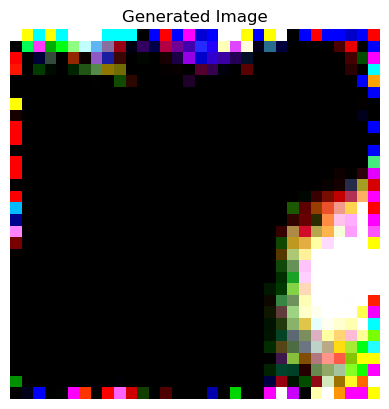

In [14]:
import matplotlib.pyplot as plt
import torchvision.transforms as T

# Convert and clamp to [0, 1] if needed
img = x_t[0].detach().cpu()
img = torch.clamp(img, 0.0, 1.0)
img = T.ToPILImage()(img)

plt.imshow(img)
plt.axis('off')
plt.title("Generated Image")
plt.show()


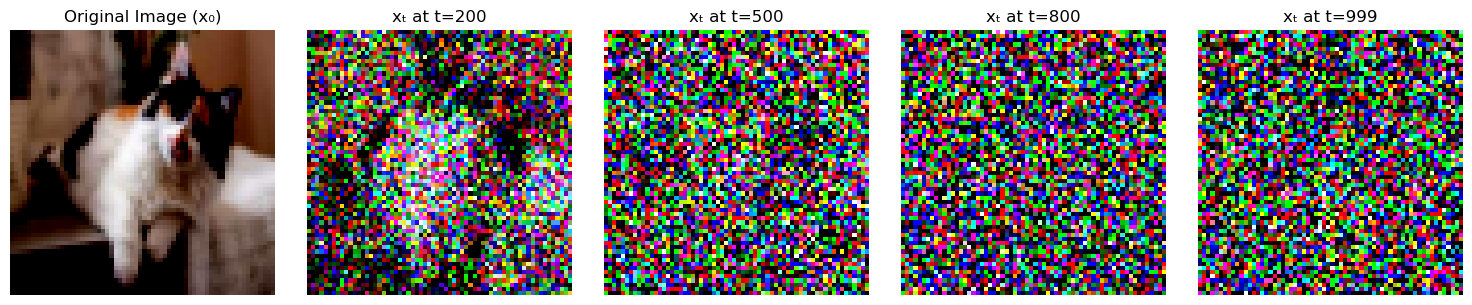

In [20]:
import matplotlib.pyplot as plt
import torchvision.transforms as T

# Select one image from your dataset

for x0, _ in dataloader:
    x0 = x0.to(device)
    break  # Take the first image only

x0_single = x0[0]  # take one sample from batch


# Noise schedule
T_total = 1000
betas, alphas, alpha_bars = get_noise_schedule(T=T_total)

# Time steps to visualize
t_steps = [200, 500, 800, 999]

# Image list to store for plotting
images = [x0_single.cpu()]
titles = ['Original Image (x₀)']

for t in t_steps:
    t_tensor = torch.tensor([t], device=device).long()
    noise = torch.randn_like(x0_single)
    x_t = q_sample(x0_single.unsqueeze(0), t_tensor, alpha_bars)[0]  # remove batch dim
    images.append(x_t.cpu())
    titles.append(f"xₜ at t={t}")

# Plotting
to_pil = T.ToPILImage()
plt.figure(figsize=(15, 3))
for i, (img_tensor, title) in enumerate(zip(images, titles)):
    img = torch.clamp(img_tensor, 0.0, 1.0)
    plt.subplot(1, len(images), i+1)
    plt.imshow(to_pil(img.squeeze(0)))  # Removes extra batch dim if present
    plt.title(title)
    plt.axis('off')

plt.tight_layout()
plt.savefig("intermediate_noising_steps.png")
plt.show()


In [21]:
x = x_t.to(device)  # Move noisy image to GPU
with torch.no_grad():
    for t in reversed(range(1, T_total)):
        t_tensor = torch.full((1,), t, device=device, dtype=torch.long)

        # Predict noise at timestep t
        predicted_noise = model(x, t_tensor)

        # Get betas, alphas
        alpha = alphas[t]
        alpha_bar = alpha_bars[t]
        beta = betas[t]

        # Compute mean estimate of x_{t-1}
        mean = (1 / alpha.sqrt()) * (x - ((1 - alpha) / (1 - alpha_bar).sqrt()) * predicted_noise)

        # Add noise unless final step
        if t > 1:
            noise = torch.randn_like(x)
            x = mean + beta.sqrt() * noise
        else:
            x = mean


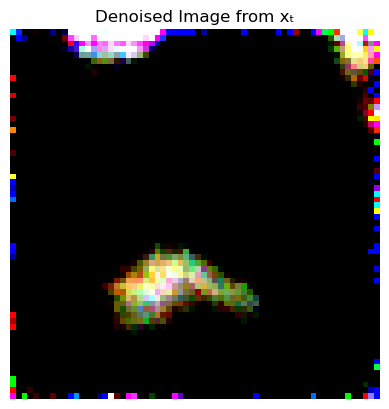

In [ ]:
img = x.squeeze(0).detach().cpu()
img = torch.clamp(img, 0.0, 1.0)
plt.imshow(T.ToPILImage()(img))
plt.title("Denoised Image from xt")
plt.axis('off')
plt.show()
